In [1]:
!pip install -U tensorflow==2.10.0 keras==2.10.0 segmentation-models==1.0.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 48.3 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-s

In [2]:
import glob
import pandas as pd
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from zipfile import ZipFile
import cv2
import os
from pylab import rcParams
from sklearn.model_selection import train_test_split
import imgaug as ia
import imgaug.augmenters as iaa
from keras.callbacks import Callback
from keras.losses import binary_crossentropy
from keras.models import Model
from keras.layers import Input, BatchNormalization, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from keras.optimizers import Adam
from keras import backend as K
import segmentation_models as sm

print("TensorFlow Version: ", tf.__version__)
print("Eager Execution: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")


Segmentation Models: using `keras` framework.
TensorFlow Version:  2.10.0
Eager Execution:  True
GPU is NOT AVAILABLE


In [3]:
import pandas as pd
import os

# Replace with the path to your dataset
metadata_path = "/content/drive/MyDrive/MLProject/metadata.csv"  # Update this path
raw_data = pd.read_csv(metadata_path)

# Display the first few rows of metadata to confirm successful loading
print("Metadata loaded successfully:")
raw_data.head()

Metadata loaded successfully:


,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,/content/drive/MyDrive/MLProject/data/COVID-19...,/content/drive/MyDrive/MLProject/data/Lung_Mas...,/content/drive/MyDrive/MLProject/data/Infectio...,/content/drive/MyDrive/MLProject/data/Lung_and...
1,/content/drive/MyDrive/MLProject/data/COVID-19...,/content/drive/MyDrive/MLProject/data/Lung_Mas...,/content/drive/MyDrive/MLProject/data/Infectio...,/content/drive/MyDrive/MLProject/data/Lung_and...
2,/content/drive/MyDrive/MLProject/data/COVID-19...,/content/drive/MyDrive/MLProject/data/Lung_Mas...,/content/drive/MyDrive/MLProject/data/Infectio...,/content/drive/MyDrive/MLProject/data/Lung_and...
3,/content/drive/MyDrive/MLProject/data/COVID-19...,/content/drive/MyDrive/MLProject/data/Lung_Mas...,/content/drive/MyDrive/MLProject/data/Infectio...,/content/drive/MyDrive/MLProject/data/Lung_and...
4,/content/drive/MyDrive/MLProject/data/COVID-19...,/content/drive/MyDrive/MLProject/data/Lung_Mas...,/content/drive/MyDrive/MLProject/data/Infectio...,/content/drive/MyDrive/MLProject/data/Lung_and...


CT Scans: 2112
Lung Masks: 0
Infection Masks: 2112
Processed CT Scans: 1431
Processed Infection Masks: 1431
Final Processed CT Scans: (1431, 224, 224, 1)
Final Processed Infection Masks: (1431, 224, 224, 1)


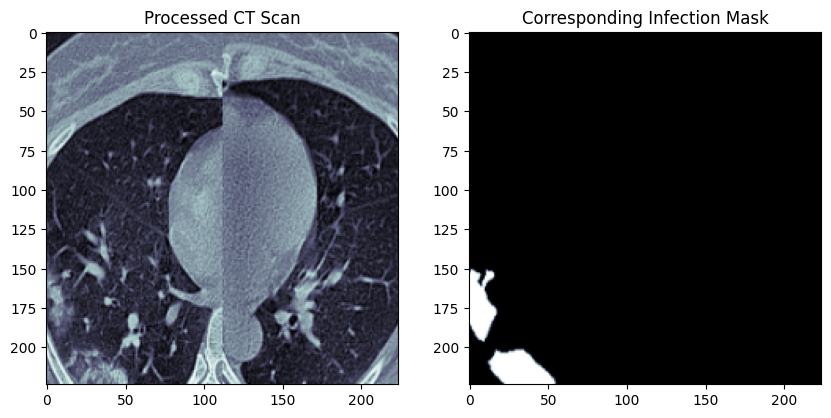

In [4]:
import numpy as np
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import random  # Import random

# Global Constants
img_size = 512  # Preferred intermediate image size
new_dim = 224   # Final image dimension for resizing

# CLAHE Enhancer
def clahe_enhancer(test_img, demo=False):
    test_img = np.uint8(test_img * 255)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_image = clahe.apply(test_img)

    if demo:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(test_img, cmap='bone')
        ax[0].set_title("Original CT-Scan")
        ax[1].imshow(clahe_image, cmap='bone')
        ax[1].set_title("CLAHE Enhanced CT-Scan")
        plt.show()

    return clahe_image

# Cropper Function
def cropper(test_img):
    test_img = np.uint8(test_img * 255)
    contours, _ = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]

    if len(areas) < 2:  # Not enough contours to crop
        return None, None, None

    x = np.argsort(areas)
    max_index, second_max_index = x[-1], x[-2]

    cnt1, cnt2 = contours[max_index], contours[second_max_index]
    x1, y1, w1, h1 = cv2.boundingRect(cnt1)
    x2, y2, w2, h2 = cv2.boundingRect(cnt2)

    points1 = [x1, y1, w1, h1]
    points2 = [x2, y2, w2, h2]

    cropped1 = cv2.resize(test_img[y1:y1+h1, x1:x1+w1], (125, 250))
    cropped2 = cv2.resize(test_img[y2:y2+h2, x2:x2+w2], (125, 250))
    fused = np.concatenate((cropped1, cropped2), axis=1)

    return fused, points1, points2

# Read `.nii` File with Lung Mask Processing
all_points1 = []
all_points2 = []

def read_nii(filepath, data, mode):
    global all_points1, all_points2
    ct_scan = nib.load(filepath)
    array = np.rot90(ct_scan.get_fdata())
    slices = array.shape[2]
    array = array[:, :, round(slices * 0.2):round(slices * 0.8)]  # Trim unneeded slices
    array = np.rollaxis(array, 2)

    for img_no in range(array.shape[0]):
        img = cv2.resize(array[img_no], (img_size, img_size))
        # Avoid division by zero
        if img.max() == img.min():
            img = np.zeros_like(img)
        else:
            img = (img - img.min()) / (img.max() - img.min())

        if mode == "lungs":
            img[img > 0] = 1
            cropped_img, points1, points2 = cropper(img)
            if cropped_img is not None:
                all_points1.append(points1)
                all_points2.append(points2)
            continue

        if mode == "cts" and img_no < len(all_points1):
            img = clahe_enhancer(img)
            a, b, c, d = all_points1[img_no]
            e, f, g, h = all_points2[img_no]
            img1 = cv2.resize(img[b:b+d, a:a+c], (125, 250))
            img2 = cv2.resize(img[f:f+h, e:e+g], (125, 250))
            img = np.concatenate((img1, img2), axis=1)

        if mode == "infections" and img_no < len(all_points1):
            a, b, c, d = all_points1[img_no]
            e, f, g, h = all_points2[img_no]
            img1 = cv2.resize(img[b:b+d, a:a+c], (125, 250))
            img2 = cv2.resize(img[f:f+h, e:e+g], (125, 250))
            img = np.concatenate((img1, img2), axis=1)

        data.append(img)

# Processing CT Scans, Lung Masks, and Infection Masks
cts, lungs, infections = [], [], []

for i in range(len(raw_data)):
    read_nii(raw_data.loc[i, 'lung_mask'], lungs, "lungs")
    read_nii(raw_data.loc[i, 'ct_scan'], cts, "cts")
    read_nii(raw_data.loc[i, 'infection_mask'], infections, "infections")

print("CT Scans:", len(cts))
print("Lung Masks:", len(lungs))
print("Infection Masks:", len(infections))

# Removing Blank Masks
no_masks = [i for i, mask in enumerate(infections) if np.unique(mask).size == 1]
for index in sorted(no_masks, reverse=True):
    del cts[index]
    del infections[index]

print("Processed CT Scans:", len(cts))
print("Processed Infection Masks:", len(infections))

# Resize for Uniformity
cts = [cv2.resize(img, (new_dim, new_dim)) for img in cts]
infections = [cv2.resize(mask, (new_dim, new_dim)) for mask in infections]

cts = np.array(cts).reshape(-1, new_dim, new_dim, 1) / 255
infections = np.array(infections).reshape(-1, new_dim, new_dim, 1) / 255

print("Final Processed CT Scans:", cts.shape)
print("Final Processed Infection Masks:", infections.shape)

# Visualize a Random Sample
index = random.randint(0, len(cts) - 1)  # Ensure random is imported
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cts[index].squeeze(), cmap='bone')
plt.title("Processed CT Scan")
plt.subplot(1, 2, 2)
plt.imshow(infections[index].squeeze(), cmap='bone')
plt.title("Corresponding Infection Mask")
plt.show()


In [5]:
import numpy as np
import cv2
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split

# Define global variables
img_size = 512
new_dim = 224

# CLAHE enhancement function
def clahe_enhancer(test_img):
    test_img = np.uint8(test_img * 255)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    return clahe.apply(test_img)

# Crop function
def cropper(test_img):
    test_img = np.uint8(test_img * 255)
    contours, _ = cv2.findContours(test_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    areas = [cv2.contourArea(c) for c in contours]

    if len(areas) < 2:
        return None, None, None

    x = np.argsort(areas)
    max_index, second_max_index = x[-1], x[-2]

    cnt1, cnt2 = contours[max_index], contours[second_max_index]
    x1, y1, w1, h1 = cv2.boundingRect(cnt1)
    x2, y2, w2, h2 = cv2.boundingRect(cnt2)

    points1 = [x1, y1, w1, h1]
    points2 = [x2, y2, w2, h2]

    cropped1 = cv2.resize(test_img[y1:y1+h1, x1:x1+w1], (125, 250))
    cropped2 = cv2.resize(test_img[y2:y2+h2, x2:x2+w2], (125, 250))
    fused = np.concatenate((cropped1, cropped2), axis=1)

    return fused, points1, points2

# Read NIfTI function
all_points1 = []
all_points2 = []

def read_nii(filepath, data, mode):
    global all_points1, all_points2
    ct_scan = nib.load(filepath)
    array = np.rot90(ct_scan.get_fdata())
    slices = array.shape[2]
    array = array[:, :, round(slices * 0.2):round(slices * 0.8)]
    array = np.rollaxis(array, 2)

    for img_no in range(array.shape[0]):
        img = cv2.resize(array[img_no], (img_size, img_size))
        # Handle division by zero
        if img.max() == img.min():
            img = np.zeros_like(img)  # Set to zeros if all pixels are identical
        else:
            img = (img - img.min()) / (img.max() - img.min())

        if mode == "lungs":
            img[img > 0] = 1
            cropped_img, points1, points2 = cropper(img)
            if cropped_img is not None:
                all_points1.append(points1)
                all_points2.append(points2)
            continue

        if mode == "cts" and img_no < len(all_points1):
            img = clahe_enhancer(img)
            a, b, c, d = all_points1[img_no]
            e, f, g, h = all_points2[img_no]
            img1 = cv2.resize(img[b:b+d, a:a+c], (125, 250))
            img2 = cv2.resize(img[f:f+h, e:e+g], (125, 250))
            img = np.concatenate((img1, img2), axis=1)

        if mode == "infections" and img_no < len(all_points1):
            a, b, c, d = all_points1[img_no]
            e, f, g, h = all_points2[img_no]
            img1 = cv2.resize(img[b:b+d, a:a+c], (125, 250))
            img2 = cv2.resize(img[f:f+h, e:e+g], (125, 250))
            img = np.concatenate((img1, img2), axis=1)

        data.append(img)

# Load and preprocess data
cts, lungs, infections = [], [], []

for i in range(len(raw_data)):
    read_nii(raw_data.loc[i, 'lung_mask'], lungs, "lungs")
    read_nii(raw_data.loc[i, 'ct_scan'], cts, "cts")
    read_nii(raw_data.loc[i, 'infection_mask'], infections, "infections")

print("CT Scans:", len(cts))
print("Lung Masks:", len(lungs))
print("Infection Masks:", len(infections))

# Resize and normalize
cts = [cv2.resize(img, (new_dim, new_dim)) for img in cts]
infections = [cv2.resize(mask, (new_dim, new_dim)) for mask in infections]

cts = np.array(cts).reshape(-1, new_dim, new_dim, 1)
infections = np.array(infections).reshape(-1, new_dim, new_dim, 1)

print("Processed CT Scans:", cts.shape)
print("Processed Infection Masks:", infections.shape)

# Data Augmentation
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

def augment_data(images, masks, augmenters):
    aug_images = []
    aug_masks = []

    for i in range(len(images)):
        mask_map = SegmentationMapsOnImage(masks[i], shape=images[i].shape)
        augmented = augmenters(image=images[i], segmentation_maps=mask_map)
        aug_images.append(augmented[0])
        aug_masks.append(augmented[1].arr)

    return np.array(aug_images), np.array(aug_masks)

cts_uint8 = (cts * 255).astype(np.uint8)
masks_uint8 = (infections * 255).astype(np.uint8)

augmenters = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Affine(rotate=(-20, 20)),
    iaa.Affine(scale=(0.9, 1.1))
])

aug_cts, aug_masks = augment_data(cts_uint8, masks_uint8, augmenters)

cts_combined = np.concatenate([cts_uint8, aug_cts], axis=0).astype(np.float32) / 255
masks_combined = np.concatenate([masks_uint8, aug_masks], axis=0).astype(np.float32) / 255

print(f"Original CT Scans: {cts.shape}")
print(f"Augmented CT Scans: {aug_cts.shape}")
print(f"Combined CT Scans: {cts_combined.shape}")
print(f"Combined Masks: {masks_combined.shape}")

X_train, X_test, Y_train, Y_test = train_test_split(cts_combined, masks_combined, test_size=0.2, random_state=42)

print(f"Training Data: {X_train.shape}, {Y_train.shape}")
print(f"Testing Data: {X_test.shape}, {Y_test.shape}")


CT Scans: 2112
Lung Masks: 0
Infection Masks: 2112
Processed CT Scans: (2112, 224, 224, 1)
Processed Infection Masks: (2112, 224, 224, 1)
Original CT Scans: (2112, 224, 224, 1)
Augmented CT Scans: (2112, 224, 224, 1)
Combined CT Scans: (4224, 224, 224, 1)
Combined Masks: (4224, 224, 224, 1)
Training Data: (3379, 224, 224, 1), (3379, 224, 224, 1)
Testing Data: (845, 224, 224, 1), (845, 224, 224, 1)


In [6]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the U-Net model
def unet_model(input_size=(224, 224, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(0.25)(p1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(0.25)(p2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(0.25)(p3)

    c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(0.25)(p4)

    c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(p4)
    c5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c5)

    # Decoder
    u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(u6)
    c6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c6)

    u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(u7)
    c7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c7)

    u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(u8)
    c8 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c8)

    u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(u9)
    c9 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer="he_normal")(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Initialize and compile the model
model = unet_model()
model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 224, 224, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Define callbacks
checkpoint = ModelCheckpoint(
    filepath="unet_infection_segmentation.h5",
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min",
    save_weights_only=False  # Save the entire model, not just weights
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    x=X_train,
    y=Y_train,
    validation_data=(X_test, Y_test),
    epochs=50,
    batch_size=16,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/50
212/212 [==============================] - ETA: 0s - loss: 0.1240 - accuracy: 0.9548
Epoch 1: val_loss improved from inf to 0.33907, saving model to unet_infection_segmentation.h5
212/212 [==============================] - 1374s 6s/step - loss: 0.1240 - accuracy: 0.9548 - val_loss: 0.3391 - val_accuracy: 0.9583 - lr: 5.0000e-04
Epoch 2/50
212/212 [==============================] - ETA: 0s - loss: 0.0734 - accuracy: 0.9668
Epoch 2: val_loss improved from 0.33907 to 0.11040, saving model to unet_infection_segmentation.h5
212/212 [==============================] - 1370s 6s/step - loss: 0.0734 - accuracy: 0.9668 - val_loss: 0.1104 - val_accuracy: 0.9645 - lr: 5.0000e-04
Epoch 3/50
212/212 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9720
Epoch 3: val_loss improved from 0.11040 to 0.09438, saving model to unet_infection_segmentation.h5
212/212 [==============================] - 1368s 6s/step - loss: 0.0570 - accuracy: 0.9720 - val_loss: 0.0944 - val_acc

In [8]:
# Save in .h5 format
model.save("unet_infection_segmentation.h5")

# Save in SavedModel format
model.save("unet_infection_segmentation_savedmodel", save_format="tf")


In [9]:
from tensorflow.keras.models import load_model

try:
    model = load_model("unet_infection_segmentation.h5")
    print("Model loaded successfully from .h5 file!")
except OSError as e:
    print(f"Error loading .h5 file: {e}")


Model loaded successfully from .h5 file!


In [10]:
from tensorflow.keras.models import load_model

try:
    model = load_model("unet_infection_segmentation_savedmodel")
    print("Model loaded successfully from SavedModel format!")
except OSError as e:
    print(f"Error loading SavedModel format: {e}")


Model loaded successfully from SavedModel format!


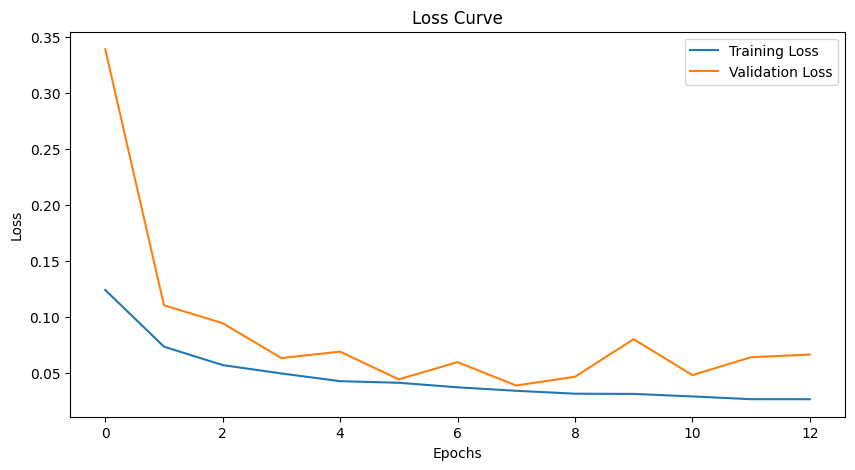

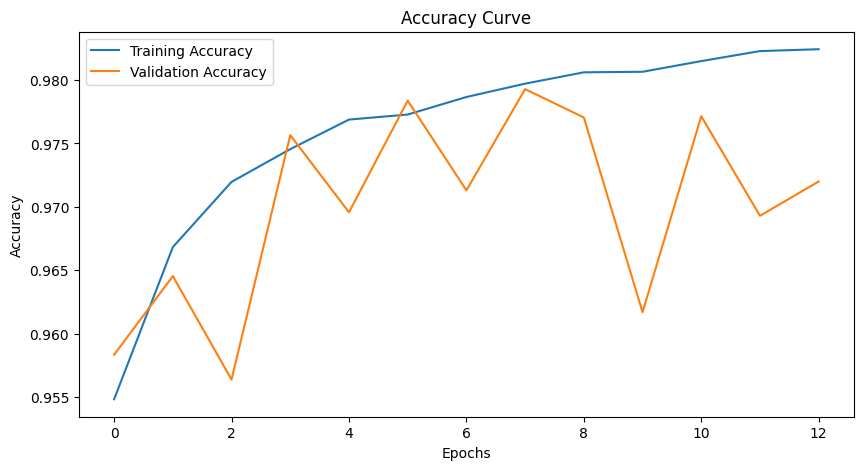

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, Y_test, batch_size=32)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


27/27 [==============================] - 78s 3s/step - loss: 0.0387 - accuracy: 0.9793
Test Loss: 0.03870076686143875
Test Accuracy: 0.9792910814285278


In [13]:
def dice_coefficient(y_true, y_pred):
    smooth = 1e-6
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    intersection = np.sum(y_true_flat * y_pred_flat)
    return (2. * intersection + smooth) / (np.sum(y_true_flat) + np.sum(y_pred_flat) + smooth)

def iou_score(y_true, y_pred):
    smooth = 1e-6
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    intersection = np.sum(y_true_flat * y_pred_flat)
    union = np.sum(y_true_flat) + np.sum(y_pred_flat) - intersection
    return (intersection + smooth) / (union + smooth)

# Evaluate on test set
y_pred = model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(np.float32)

dice_scores = [dice_coefficient(Y_test[i], y_pred_binary[i]) for i in range(len(Y_test))]
iou_scores = [iou_score(Y_test[i], y_pred_binary[i]) for i in range(len(Y_test))]

print(f"Mean Dice Coefficient: {np.mean(dice_scores):.4f}")
print(f"Mean IoU Score: {np.mean(iou_scores):.4f}")


27/27 [==============================] - 77s 3s/step
Mean Dice Coefficient: 0.7210
Mean IoU Score: 0.6450


1/1 [==============================] - 0s 104ms/step


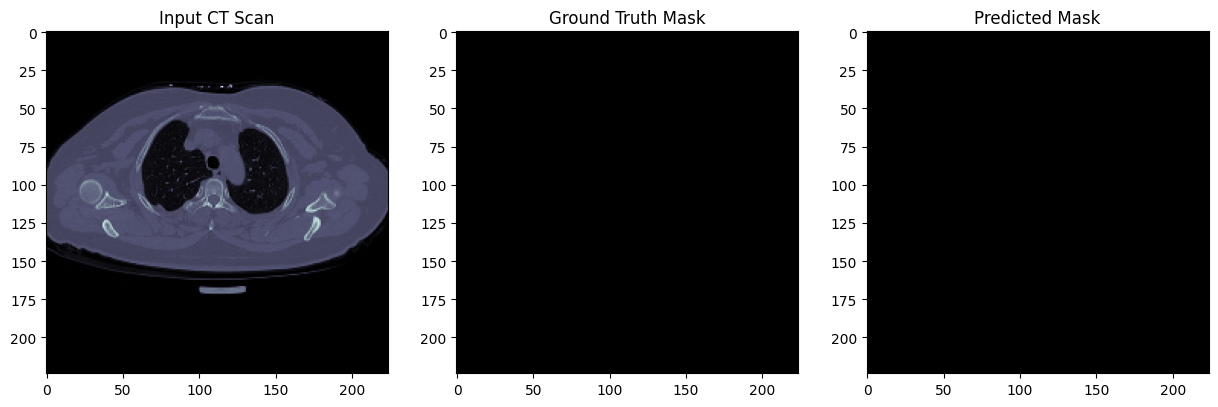

1/1 [==============================] - 0s 108ms/step


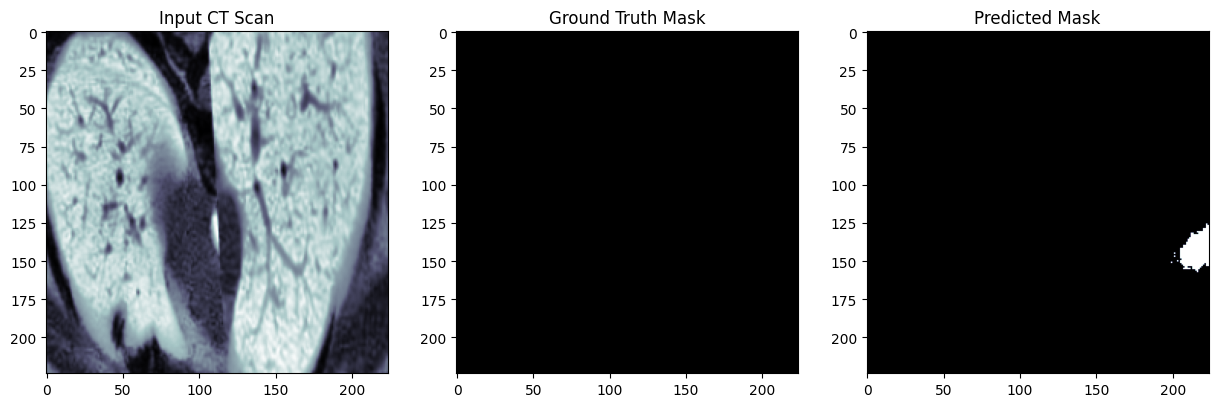

1/1 [==============================] - 0s 106ms/step


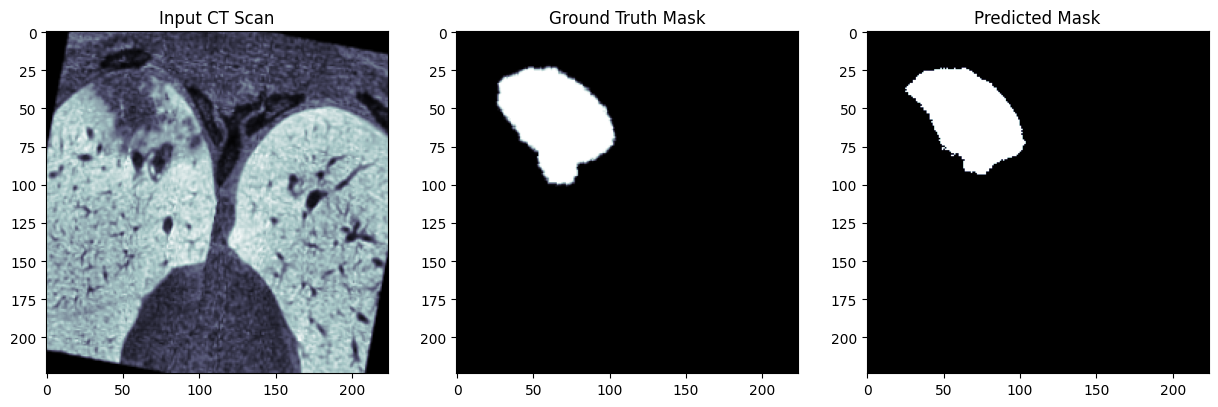

1/1 [==============================] - 0s 101ms/step


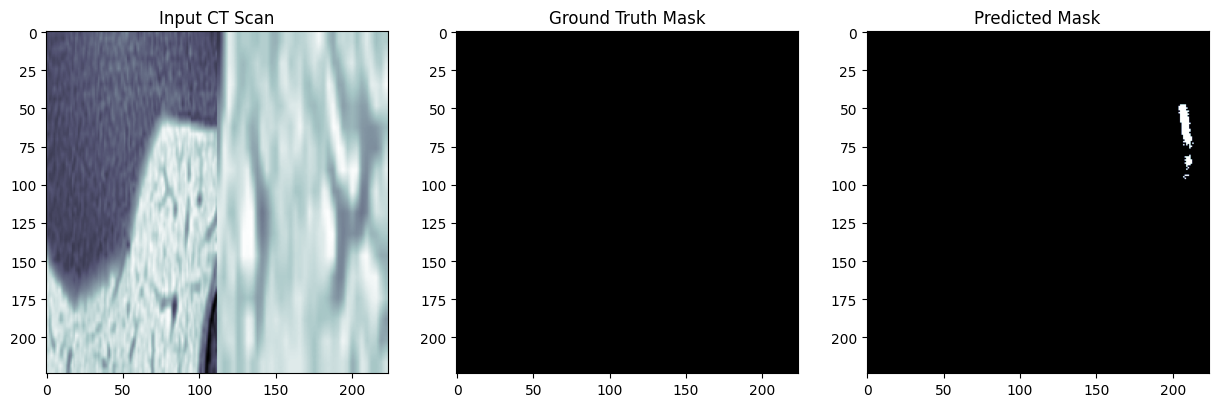

1/1 [==============================] - 0s 107ms/step


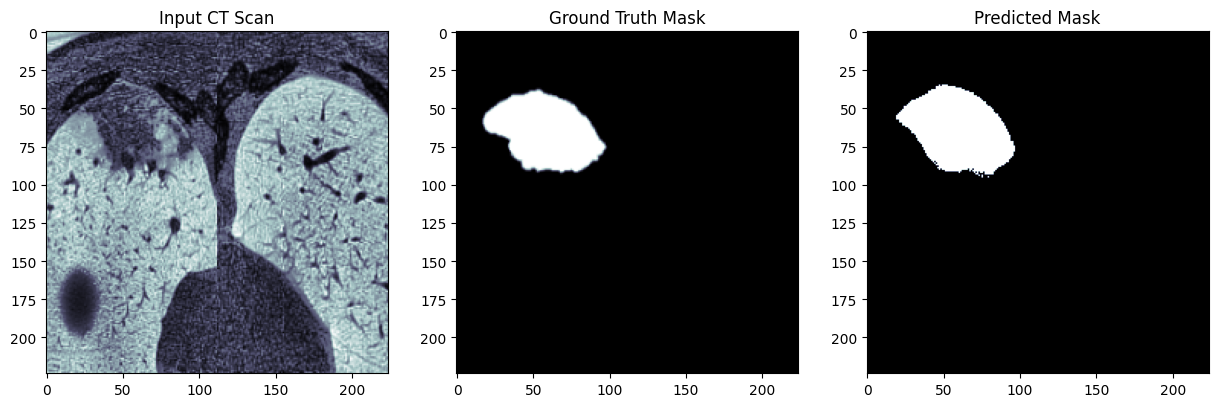

In [14]:
import random

def visualize_predictions(model, X, Y, idx=None):
    if idx is None:
        idx = random.randint(0, len(X) - 1)

    pred = model.predict(X[idx].reshape(1, 224, 224, 1))[0]
    pred_binary = (pred > 0.5).astype(np.float32)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(X[idx].squeeze(), cmap='bone')
    plt.title("Input CT Scan")

    plt.subplot(1, 3, 2)
    plt.imshow(Y[idx].squeeze(), cmap='bone')
    plt.title("Ground Truth Mask")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_binary.squeeze(), cmap='bone')
    plt.title("Predicted Mask")

    plt.show()

# Visualize random predictions
for _ in range(5):
    visualize_predictions(model, X_test, Y_test)


Test images saved in: /content/test_images
Processed test images shape: (5, 224, 224, 1)
1/1 [==============================] - 1s 682ms/step


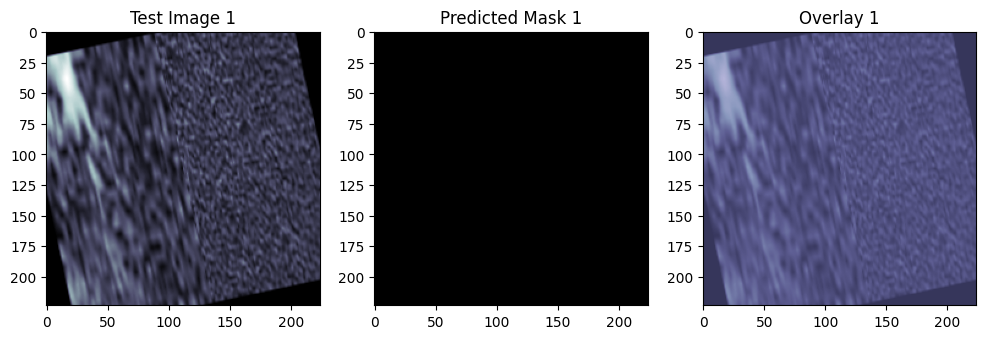

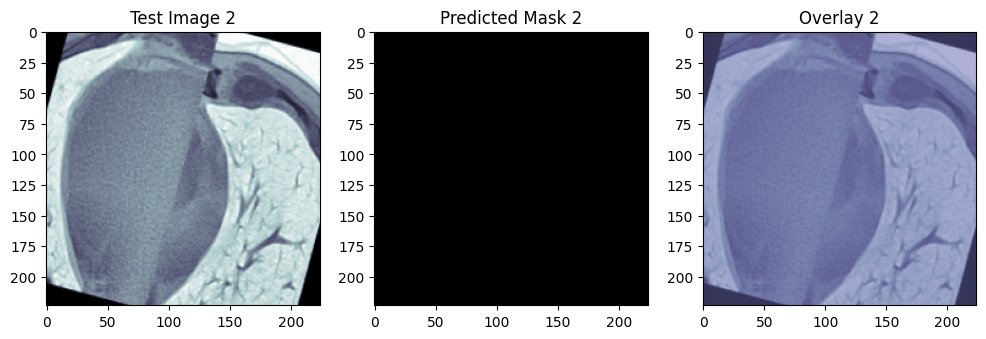

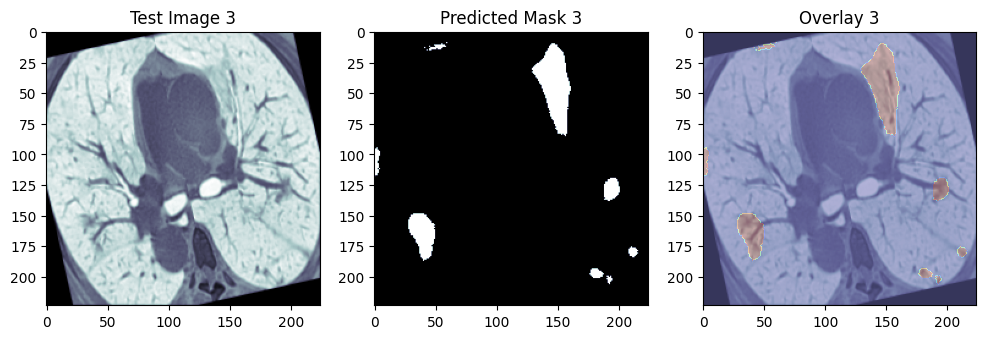

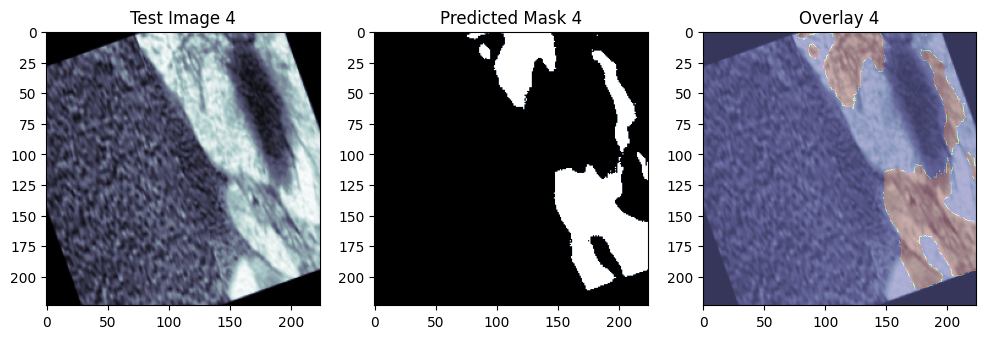

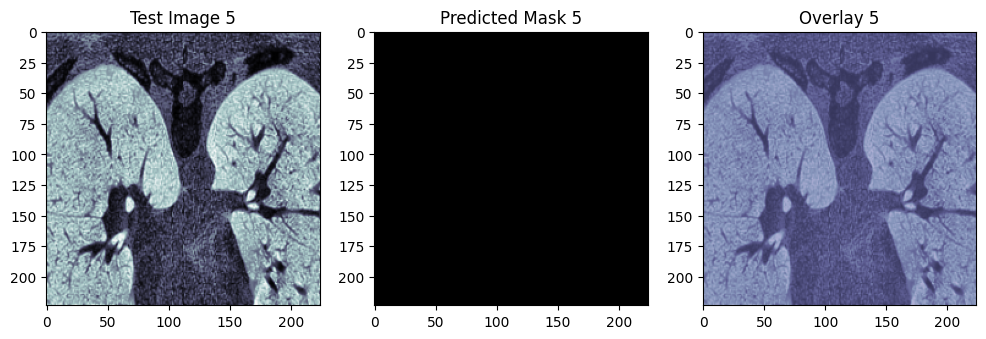

In [15]:
import os
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Define folder paths
test_folder = "/content/test_images_infection"
os.makedirs(test_folder, exist_ok=True)

# Copy 5 random CT scans from the training set as test images
for i in range(5):
    img_path = os.path.join(test_folder, f"test_image_{i+1}.png")
    cv2.imwrite(img_path, (X_test[i] * 255).astype(np.uint8))

print(f"Test images saved in: {test_folder}")

# Preprocessing for test images
def preprocess_image(image_path):
    """
    Preprocesses a single image for the U-Net model.
    1. Reads the image.
    2. Resizes it to the required dimensions (224x224).
    3. Normalizes the pixel values (0 to 1).
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))
    img = img.astype(np.float32) / 255.0  # Normalize to 0-1
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return img

# Preprocess all test images
test_images = []
test_image_paths = sorted(os.listdir(test_folder))

for image_name in test_image_paths:
    image_path = os.path.join(test_folder, image_name)
    test_images.append(preprocess_image(image_path))

test_images = np.array(test_images)
print(f"Processed test images shape: {test_images.shape}")

# Load the saved model
model_path = "unet_infection_segmentation.h5"  # Replace with your saved model path
model = load_model(model_path)

# Predict on test images
predictions = model.predict(test_images)
predictions_binary = (predictions > 0.5).astype(np.float32)

# Visualize predictions
def visualize_test_predictions(test_images, predictions_binary):
    for i in range(len(test_images)):
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 3, 1)
        plt.imshow(test_images[i].squeeze(), cmap='bone')
        plt.title(f"Test Image {i+1}")

        # Predicted Mask
        plt.subplot(1, 3, 2)
        plt.imshow(predictions_binary[i].squeeze(), cmap='bone')
        plt.title(f"Predicted Mask {i+1}")

        # Combined Visualization
        plt.subplot(1, 3, 3)
        plt.imshow(test_images[i].squeeze(), cmap='bone', alpha=0.7)
        plt.imshow(predictions_binary[i].squeeze(), cmap='jet', alpha=0.3)
        plt.title(f"Overlay {i+1}")

        plt.show()

# Visualize predictions for the test images
visualize_test_predictions(test_images, predictions_binary)


In [16]:
import os
import cv2
import numpy as np

# Create a test folder
test_folder = "test_images"
os.makedirs(test_folder, exist_ok=True)

# Save 5 images from X_test into the test folder
for i in range(5):
    img_path = os.path.join(test_folder, f"test_image_{i+1}.png")
    cv2.imwrite(img_path, (X_test[i] * 255).astype(np.uint8))

print(f"Test images saved in: {test_folder}")


Test images saved in: test_images


In [17]:
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the saved model
model = load_model("unet_infection_segmentation.h5")

# Define preprocessing function
def preprocess_image(image_path):
    """
    Preprocess a single image:
    1. Load the image as grayscale.
    2. Resize to the model's input size.
    3. Normalize pixel values to [0, 1].
    """
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224, 224))  # Resize to model input size
    img = img.astype(np.float32) / 255.0  # Normalize
    img = np.expand_dims(img, axis=-1)  # Add channel dimension
    return img

# Predict function
def predict_mask(image_path):
    """
    Predict the segmented mask for the given image.
    """
    # Preprocess the image
    img = preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    # Predict the mask
    predicted_mask = model.predict(img)[0]

    # Threshold the mask
    predicted_mask_binary = (predicted_mask > 0.5).astype(np.uint8)

    return img[0], predicted_mask_binary

# Visualize prediction
def visualize_prediction(image_path):
    """
    Display the input image and its predicted segmentation mask.
    """
    input_img, pred_mask = predict_mask(image_path)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(input_img.squeeze(), cmap="bone")
    plt.title("Input Image")

    plt.subplot(1, 2, 2)
    plt.imshow(pred_mask.squeeze(), cmap="jet")
    plt.title("Predicted Segmentation Mask")

    plt.show()


Available test images:
1. test_image_1.png
2. test_image_2.png
3. test_image_3.png
4. test_image_4.png
5. test_image_5.png
Enter the number of the image you want to test (1-5): 4
Selected image: test_images/test_image_4.png
1/1 [==============================] - 0s 344ms/step


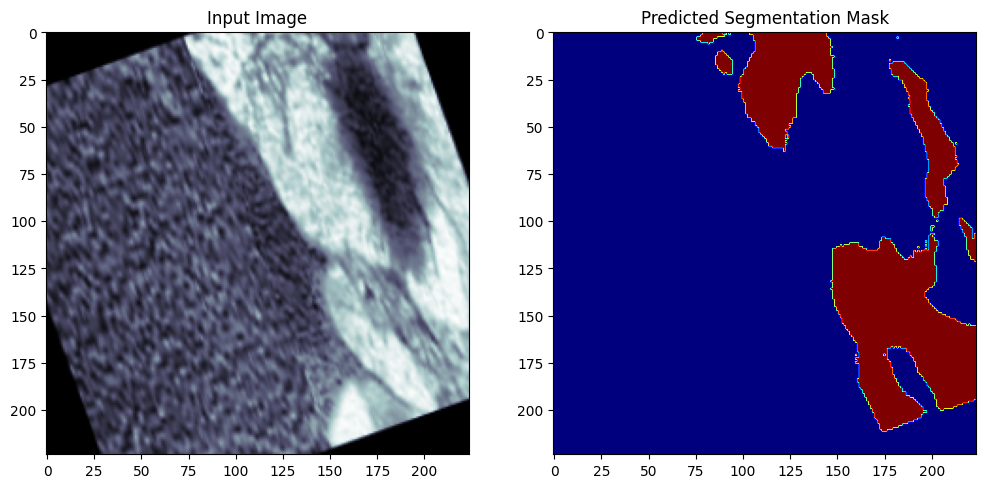

In [18]:
# List images in the test folder
test_images = sorted(os.listdir(test_folder))
print("Available test images:")
for i, image_name in enumerate(test_images):
    print(f"{i + 1}. {image_name}")

# Ask the user to select an image by entering the index
selected_index = int(input("Enter the number of the image you want to test (1-5): ")) - 1
if selected_index < 0 or selected_index >= len(test_images):
    print("Invalid selection. Please run the script again.")
else:
    selected_image_path = os.path.join(test_folder, test_images[selected_index])
    print(f"Selected image: {selected_image_path}")

    # Visualize the prediction
    visualize_prediction(selected_image_path)
